In [1]:
import nrrd
import numpy as np
from utils import imshow

# readdata, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation.seg.nrrd')
labeldata_load, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation-label.nrrd')
image_load, header2 = nrrd.read('../data/1241031155/9.40CHESTABDPELVIS.nrrd')

In [16]:
image = image_load
labeldata = labeldata_load
print(image.shape)
print(labeldata.shape)
# imshow(image)
# imshow(labeldata)

image = np.swapaxes(image, 0, 2)
labeldata = np.swapaxes(labeldata, 0, 2)
print(image.shape)
print(labeldata.shape)

(512, 512, 265)
(512, 512, 265)
(265, 512, 512)
(265, 512, 512)


In [17]:

lbl = labeldata[[132],...] #takes one slice of the 265
print(lbl.shape)
# imshow(lbl)

print(lbl)
np.any(lbl)

# right now for the labels, the area containing the tumor is represented by 1s; every other pixel is 0
# do we need to make the labels for each slice binary in [0, 1]?  or do we keep the labels for each slice
# as a 2d array containing 0s and 1s?

(1, 512, 512)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


True

In [18]:


#add the fourth dimension (modality) which is just 1
image = np.expand_dims(image, axis=3)
labeldata = np.expand_dims(labeldata, axis=3)

print(image.shape)
print(labeldata.shape)
# imshow(image)
# imshow(labeldata)

(265, 512, 512, 1)
(265, 512, 512, 1)


(1, 512, 512, 1)
(1, 512, 512, 1)


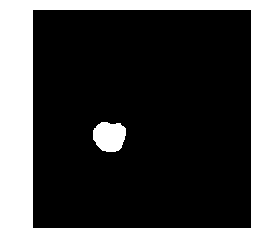

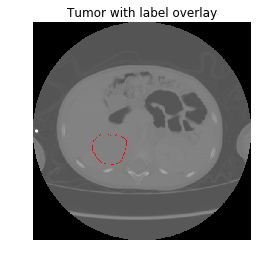

In [19]:
lbl = labeldata[[132],...] #takes one slice of the 265
img = image[[132],...] #takes one slice of the 265

print(img.shape)
print(lbl.shape)

# imshow(img)
imshow(lbl)
imshow(dat=img, lbl=lbl, title='Tumor with label overlay')

In [20]:
import tensorflow as tf


print(type(img))
print(img.shape)


X = tf.placeholder(tf.float32, [None, 512, 512, 1])

conv = tf.layers.conv2d(X, filters=8, kernel_size=(3, 3), padding='same')
relu = tf.nn.relu(conv)
pool = tf.layers.max_pooling2d(relu, pool_size=(2, 2), strides=(2, 2))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

output = sess.run(pool, feed_dict={X: img})

print(output.shape)

<class 'numpy.ndarray'>
(1, 512, 512, 1)
(1, 256, 256, 8)


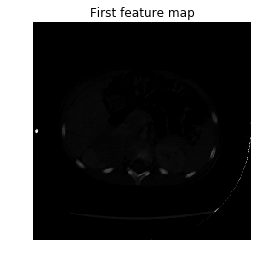

In [21]:
imshow(output[..., 0], title='First feature map')


In [22]:
sess.close()


In [23]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 512, 512, 1], name='X')
y = tf.placeholder(tf.int32, shape=[None], name='y')
mode = tf.placeholder(tf.bool, name='mode')

In [24]:
def l2_reg(scale):

    return tf.contrib.layers.l2_regularizer(scale)

def conv_block(layer, fsize, training, name, pool=True):
    """
    Method to perform basic CNN convolution block pattern
    
      [ CONV --> BN --> RELU ] x2 --> POOL (optional)

    :params
      
      (tf.Tensor) layer : input layer
      (int) fsize : output filter size
      (tf.Tensor) training : boolean value regarding train/valid cohort
      (str) name : name of block 
      (bool) pool : if True, pooling is performed

    :return

      (tf.Tensor) layer : output layer 

    """
    with tf.variable_scope(name):

        for i in range(1, 3):

            layer = tf.layers.conv2d(layer, filters=fsize, kernel_size=(3, 3), padding='same',
                kernel_regularizer=l2_reg(1e-1), name='conv-%i' % i)
            layer = tf.layers.batch_normalization(layer, training=training, name='norm-%s' % i)
            layer = tf.nn.relu(layer, name='relu-%i' % i)

        if pool:
            pool = tf.layers.max_pooling2d(layer, pool_size=(2, 2), strides=(2, 2), name='pool-%i' % i)

        return layer, pool

In [25]:
def create_classifier2(X, training):
    """
    Method to implement simple classifier

    :params

      (tf.Tensor) X : input tensor
      (tf.Tensor) training : boolean value regarding train/valid cohort

    :return

      (tf.Tensor) layer : output layer

    """
    print("X: ", X.shape)
    
    block1, pool1 = conv_block(X, 8, training, name='block01')
    print("pool1: ", pool1.shape)
    
    block2, pool2 = conv_block(pool1, 16, training, name='block02')
    print("pool2: ", pool2.shape)

    block3, pool3 = conv_block(pool2, 32, training, name='block03')
    print("pool3: ", pool3.shape)

    block4, pool4 = conv_block(pool3, 64, training, name='block04')
    print("pool4: ", pool4.shape)

    block5, pool5 = conv_block(pool4, 96, training, name='block05')
    print("pool5: ", pool5.shape)

    block6, pool6 = conv_block(pool5, 128, training, name='block06')
    print("pool6: ", pool6.shape)

    pool6 = tf.reshape(pool6, shape=[-1, 1, 1, 8192]) 
    print("pool6: ", pool6.shape)

    pred = tf.layers.conv2d(pool6, 2, (1, 1), name='pred', padding='same')
    pred = tf.contrib.layers.flatten(pred)

    return pred

In [26]:
pred = create_classifier2(X, training=mode)
print(pred.shape)
print(pred)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=pred)

X:  (?, 512, 512, 1)
pool1:  (?, 256, 256, 8)
pool2:  (?, 128, 128, 16)
pool3:  (?, 64, 64, 32)
pool4:  (?, 32, 32, 64)
pool5:  (?, 16, 16, 96)
pool6:  (?, 8, 8, 128)
pool6:  (?, 1, 1, 8192)
(?, 2)
Tensor("Flatten/flatten/Reshape:0", shape=(?, 2), dtype=float32)


In [ ]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)
print(lbl.shape)

In [ ]:
# dat, lbl = data.load(mode='train', n=1)
print(img.shape)
print(lbl.shape)
lbl = np.max(lbl > 0, axis=(1,2,3)).astype('int32')
sce, logits = sess.run([loss, pred], {X: img, y: lbl, mode: True})

print('REAL (tumor, y/n?): %s' % ('y' if lbl else 'n'))
print('PRED (tumor, y/n?): %s' % ('y' if logits[0, 1] > logits[0, 0] else 'n'))
print('LOSS (lower value is better prediction): %f' % sce)

imshow(img[..., 0], title='the one channel we have')
print(lbl)

In [ ]:
sess.close()

In [ ]:
# taken from: https://www.tensorflow.org/tutorials/estimators/cnn
print("new section")

In [ ]:
labeldata_load, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation-label.nrrd')
image_load, header2 = nrrd.read('../data/1241031155/9.40CHESTABDPELVIS.nrrd')

In [147]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
    
  print("*********\n\n\n\n*********")
  print(features)
  print(features["x"])
  print(labels)
  print(mode)

  input_layer = tf.reshape(features["x"], [-1, 512, 512, 1])
  print(input_layer)
  print(input_layer.shape)

   # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=8,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)   
  print("conv1: ", conv1.shape)
  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
  print("pool1: ", pool1.shape)


   # Convolutional Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=16,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)   
  print("conv2: ", conv2.shape)
  # Pooling Layer #2
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
  print("pool2: ", pool2.shape)


   # Convolutional Layer #3
  conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)   
  print("conv3: ", conv3.shape)
  # Pooling Layer #3
  pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
  print("pool3: ", pool3.shape)


   # Convolutional Layer #4
  conv4 = tf.layers.conv2d(
      inputs=pool3,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)   
  print("conv4: ", conv4.shape)
  # Pooling Layer #4
  pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)
  print("pool4: ", pool4.shape)


   # Convolutional Layer #5
  conv5 = tf.layers.conv2d(
      inputs=pool4,
      filters=96,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)   
  print("conv5: ", conv5.shape)
  # Pooling Layer #5
  pool5 = tf.layers.max_pooling2d(inputs=conv5, pool_size=[2, 2], strides=2)
  print("pool5: ", pool5.shape)


   # Convolutional Layer #6
  conv6 = tf.layers.conv2d(
      inputs=pool5,
      filters=128,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)   
  print("conv6: ", conv6.shape)
  # Pooling Layer #6
  pool6 = tf.layers.max_pooling2d(inputs=conv6, pool_size=[2, 2], strides=2)
  print("pool6: ", pool6.shape)

    
   # Dense Layer
  pool6_flat = tf.reshape(pool6, [-1, 8 * 8 * 128])
  print("pool 6 flat: ", pool6_flat.shape)
    
  dense = tf.layers.dense(inputs=pool6_flat, units=1024, activation=tf.nn.relu)
  print("dense: ", dense.shape)
    
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
  print("dropout: ", dropout.shape)   
    
    
  logits = tf.layers.dense(inputs=dropout, units=2)
  print("***********\n\n\n\n***********")
  print("logits")
  print(logits.shape)
  print(logits)
    
  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [148]:
image = image_load
labeldata = labeldata_load

labeldata = np.swapaxes(labeldata, 0, 2)

print(image.shape)
print(labeldata.shape)
# imshow(image)
# imshow(labeldata)

(512, 512, 265)
(265, 512, 512)


In [149]:
lbl_arr = np.zeros(265)
for idx, lbl_slice in enumerate(labeldata):
#     print(idx, np.any(lbl_slice))
    lbl_arr[idx] = int(np.any(lbl_slice))

In [150]:
# for idx, n in enumerate(lbl_arr):
#     print(idx, n)

image = image.reshape(-1, image.shape[-1])
image = np.swapaxes(image, 0, 1)

In [151]:
train_data = image.astype('float32')
train_labels = lbl_arr.astype('int32')
print(train_data.shape)

print(train_labels.shape)
print(type(train_labels[0]))

(265, 262144)
(265,)
<class 'numpy.int32'>


In [152]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1389a3898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [153]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [154]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=13,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=201,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
*********



*********
{'x': <tf.Tensor 'random_shuffle_queue_DequeueMany:1' shape=(13, 262144) dtype=float32>}
Tensor("random_shuffle_queue_DequeueMany:1", shape=(13, 262144), dtype=float32, device=/device:CPU:0)
Tensor("random_shuffle_queue_DequeueMany:2", shape=(13,), dtype=int32, device=/device:CPU:0)
train
Tensor("Reshape:0", shape=(13, 512, 512, 1), dtype=float32)
(13, 512, 512, 1)
conv1:  (13, 512, 512, 8)
pool1:  (13, 256, 256, 8)
conv2:  (13, 256, 256, 16)
pool2:  (13, 128, 128, 16)
conv3:  (13, 128, 128, 32)
pool3:  (13, 64, 64, 32)
conv4:  (13, 64, 64, 64)
pool4:  (13, 32, 32, 64)
conv5:  (13, 32, 32, 96)
pool5:  (13, 16, 16, 96)
conv6:  (13, 16, 16, 128)
pool6:  (13, 8, 8, 128)
pool 6 flat:  (13, 8192)
dense:  (13, 1024)
dropout:  (13, 1024)
***********



***********
logits
(13, 2)
Tensor("dense_1/BiasAdd:0", shape=(13, 2), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Gra

NotFoundError: Key conv2d_2/bias not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-154-c70345b56938>", line 11, in <module>
    hooks=[logging_hook])
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 352, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 888, in _train_model
    log_step_count_steps=self._config.log_step_count_steps) as mon_sess:
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 384, in MonitoredTrainingSession
    stop_grace_period_secs=stop_grace_period_secs)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 795, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 518, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 981, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 986, in _create_session
    return self._sess_creator.create_session()
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 675, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 437, in create_session
    self._scaffold.finalize()
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 214, in finalize
    self._saver.build()
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1302, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1339, in _build
    build_save=build_save, build_restore=build_restore)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 790, in _build_internal
    restore_sequentially, reshape)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 502, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 449, in _AddRestoreOps
    restore_sequentially)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 847, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1030, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key conv2d_2/bias not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


In [155]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

NameError: name 'eval_data' is not defined